In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics

In [2]:
train_data_ratio = 0.7

In [3]:
dfs = pd.read_excel("export.xlsx", sheetname=None)

In [4]:
df = dfs['EAI.TBLEVENT']

In [5]:
%matplotlib inline

In [6]:
all_events_list = "ENVIRONMENTAL_EVENT	PERSONALSAFETY_EVENT	PROCESSSAFETY_EVENT	RELIABILITY_EVENT	SECURITY_EVENT	QUALITY_EVENT	AUDIT_EVENT	ASSESSMENT_EVENT	BEHAVIORTRENDS_EVENT	SUCCESSANALYSIS_EVENT	OTHERLEARNINGEXPERIENCE_EV	OTHERUNPLANNED_EVENT".split("	")

In [7]:
print(all_events_list)
n_classes = len(all_events_list)

['ENVIRONMENTAL_EVENT', 'PERSONALSAFETY_EVENT', 'PROCESSSAFETY_EVENT', 'RELIABILITY_EVENT', 'SECURITY_EVENT', 'QUALITY_EVENT', 'AUDIT_EVENT', 'ASSESSMENT_EVENT', 'BEHAVIORTRENDS_EVENT', 'SUCCESSANALYSIS_EVENT', 'OTHERLEARNINGEXPERIENCE_EV', 'OTHERUNPLANNED_EVENT']


In [8]:
def get_num_of_categories(row, event_list):
    sum = 0
    for event in event_list:
        sum += row[event]
    return -sum

In [9]:
df.apply(lambda row: get_num_of_categories(row, all_events_list), axis=1)[10:20]

10    2
11    2
12    1
13    1
14    2
15    3
16    1
17    1
18    1
19    2
dtype: int64

In [10]:
df['num_of_categories'] = df.apply(lambda row: get_num_of_categories(row, all_events_list), axis=1)

(array([  3.71000000e+02,   2.75450000e+04,   1.90680000e+04,
          2.62100000e+03,   3.20000000e+02,   5.50000000e+01,
          1.30000000e+01]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

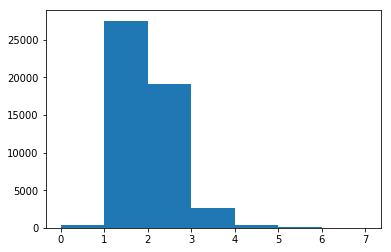

In [11]:
plt.hist(df['num_of_categories'], bins = [0, 1, 2, 3, 4, 5, 6, 7])

[393, 642, 721, 12049, 99, 933, 3544, 8107, 0, 34, 901, 122]


<Container object of 12 artists>

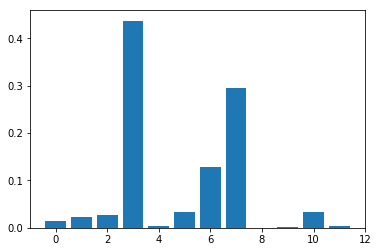

In [12]:
df_single_output = df.loc[df['num_of_categories'] == 1]
len(df_single_output)
single_cat_occur_stat = []
for event in all_events_list:
    single_cat_occur_stat.append(-df_single_output[event].sum())
print(single_cat_occur_stat)
plt.bar(range(len(all_events_list)), np.asarray(single_cat_occur_stat, dtype=np.float32)/len(df_single_output))

In [13]:
df_single_output_shuffled = df_single_output.sample(frac=1)

In [14]:
def get_category_index(row, event_list):
    index = 0
    for event in event_list:
        if row[event] == -1:
            return index
        else:
            index += 1

In [15]:
df_single_output_shuffled['index'] = df_single_output_shuffled.apply(lambda row: get_category_index(row, all_events_list), axis=1)

In [16]:
df_single_output_shuffled['index'][0:10]

37        1
29523     6
1439     10
43218     3
45100     3
35043     3
26684     3
36478     3
4960      6
6392      7
Name: index, dtype: int64

In [17]:
X_all, y_all = df_single_output_shuffled['DESCRIPTION'].values.astype('U'), df_single_output_shuffled['index'].values

In [18]:
split_index = int(train_data_ratio * len(X_all))
X_train_raw, y_train, X_test_raw, y_test = X_all[0:split_index], y_all[0:split_index], X_all[split_index:], y_all[split_index:]

In [19]:
len(X_train_raw), len(X_test_raw)
# X_train_raw[0:5]

(19281, 8264)

In [21]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

In [22]:
clf = LinearSVC(penalty="l1", dual=False, tol=1e-3)
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)

In [23]:
print(metrics.accuracy_score(y_train, clf.predict(X_train)))

0.914994035579


In [24]:
pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
score

0.80372700871248792

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


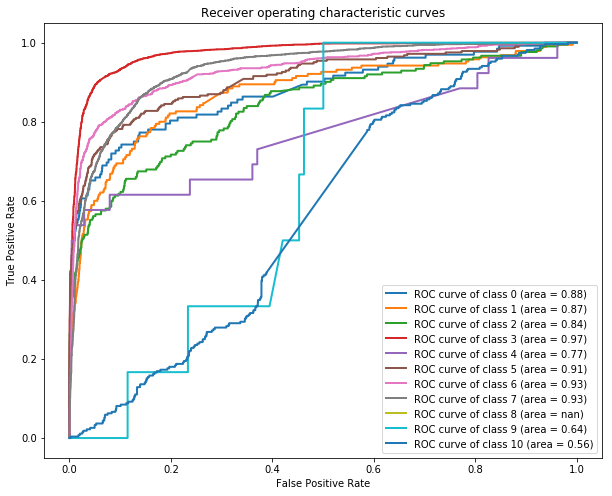

In [27]:
scores = clf.decision_function(X_test)
plt.figure(figsize=(10,8))
for i in range(n_classes - 1):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, scores[:,i], pos_label=i)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curves')
plt.legend(loc="lower right")
plt.show()